This code contains:</br></br>

Data Dictionaries: These include molecular weights, PM speciation profiles, profile names, and NMOC speciation fractions.</br></br>
Functions:</br>
calculate_base_emissions(): Calculates emissions for crop burning.</br>
calculate_pm_speciation(): Calculates PM speciation from TPM emissions.</br>
calculate_nmoc_speciation(): Calculates speciated NMOC emissions.</br>
estimate_burn_area(): Estimates the burn area for a fire detection point.</br>
process_fire_data(): Processes fire data from a CSV file and generates NetCDF files.</br>
create_netcdf(): Creates a NetCDF file with aggregated emissions data.</br>
main(): Main function to execute the processing.</br>

In [17]:
# Define the emission factors in a data dictionary
# From https://github.com/NCAR/finn/blob/master/v2.5_emissions_code/EFs_byGenVeg_c20210601.csv
emission_factors = {
    "CO2": 1444,
    "CO": 91,
    "CH4": 5.82,
    "NMOC": 51.4,
    "H2": 2.59,
    "NOXasNO": 2.43,
    "SO2": 0.4,
    # "PM25": 6.43,
    "TPM": 13,
    # "TPC": 4,
    # "OC": 2.66,
    # "BC": 0.51,
    "NH3": 2.12,
    "NO": 1.18,
    "NO2": 2.99,
    # "NMHC": 7,
    # "PM10": 7.02
}

# Define SAPRC07T VOC speciation factors based on NMOC
# These are fractions of NMOC that go to each VOC species
# From SAPRC07T mechanism specific data for agricultural burning
# For reference: https://github.com/NCAR/finn/blob/master/v2.5_emissions_code/NMOCfrac_byGenVeg_SAPRC.csv
nmoc_fractions_saprc07t = {
    "HCHO": 1.84,      # Formaldehyde
    "CCHO": 3.05,      # Acetaldehyde
    "ACET": 0.83,      # Acetone
    "MEOH": 2.11,      # Methanol
    "RCHO": 2.08,      # Higher aldehydes
    "ETHENE": 1.09,    # Ethene
    "ALK1": 1.22,      # Alkanes C2-C3
    "ALK2": 0.31,      # Alkanes C4-C5
    "ALK3": 0.02,      # Alkanes C6-C8
    "ALK4": 0.03,      # Alkanes C9-C12
    "ALK5": 0.02,      # Alkanes C13+
    "ARO1": 0.95,      # Aromatics (low SOA)
    "ARO2MN": 0.06,    # Aromatics (high SOA)
    "BALD": 0.01,      # Aromatic aldehydes
    "OLE1": 0.54,      # Alkenes C3+
    "OLE2": 0.16,      # Alkenes (high SOA)
    "TERP": 0.00,      # Terpenes
    "ISOPRENE": 0.60,  # Isoprene
    "HCOOH": 0.90,     # Formic acid
    "CCO_OH": 2.19,    # Acetic acid
    "MEK": 0.54,       # Methyl ethyl ketone
    "PHEN": 0.60,      # Phenol
    "CRES": 0.00,      # Cresol
    "MGLY": 0.19,      # Methylglyoxal
    "GLY": 0.00,       # Glyoxal
    "MVK": 0.14,       # Methyl vinyl ketone
    "PROD2": 0.11,     # Ketones
    "HONO": 0.09,      # Nitrous acid
    "IPRD": 0.00,      # Isoprene products
    "MACR": 0.00       # Methacrolein
}

# Define molecular weights for gases from GC_saprc07tc.txt
# This is used to convert from mass (g) to moles
# For reference: https://github.com/USEPA/CMAQ/blob/main/CCTM/src/MECHS/saprc07tc_ae6_aq/GC_saprc07tc_ae6_aq.nml
molecular_weights = {
    "CO2": 44.0,
    "CO": 28.0,
    "CH4": 16.0,
    "NMOC": 1.0,  # Treated as mass, use as VOC
    "H2": 2.02,
    "NOXasNO": 30.01,  # Using NO molecular weight
    "SO2": 64.1,
    # "PM25": 1.0,  # Aerosol - keep in mass units, *don't use
    "TPM": 1.0,   # Aerosol
    # "TPC": 1.0,   # Aerosol, *don't use
    # "OC": 1.0,    # Aerosol, *don't use
    # "BC": 1.0,    # Aerosol, *don't use
    "NH3": 17.0,
    "NO": 30.0,
    "NO2": 46.0,
    # "NMHC": 1.0,  # Treated as mass, Exclude as subset of NMOC
    # "PM10": 1.0   # Aerosol, *don't use
}

# PM speciation fractions for multiple agricultural burning profiles
# These values are extracted from Speciation_22AQP002 from CARB 
pm_speciation_profiles = {
    # 430: Agricultural Burning - Field Crops
    430: {
        "PAL": 0.00077,
        "PAS": 0.000006,
        "PCA": 0.000516,
        "PCD": 0.000027,
        "PCL": 0.190855,
        "PEC": 0.151748,
        "PFE": 0.00012,
        "PK": 0.147831,
        "PMC": 0.0456,
        "PMN": 0.000084,
        "PMOTHR": 0.005811,
        "PNA": 0.004665,
        "PNCOM": 0.03944,
        "PNH4": 0.039019,
        "PNI": 0.000002,
        "PNO3": 0.002838,
        "POC": 0.309575,
        "PPB": 0.00001,
        "PSI": 0.001735,
        "PSO4": 0.042836,
        "PTI": 0.000011
    },
    # 431: Rice Straw Burning
    431: {
        "PAL": 0.000073,
        "PAS": 0.000017,
        "PCA": 0.000995,
        "PCD": 0.00007,
        "PCL": 0.25214,
        "PEC": 0.185511,
        "PFE": 0.000243,
        "PK": 0.16505,
        "PMC": 0.0572,
        "PMN": 0.000264,
        "PMOTHR": 0.002454,
        "PNA": 0.007766,
        "PNCOM": 0.000018,
        "PNH4": 0.060407,
        "PNI": 0.000003,
        "PNO3": 0.002251,
        "POC": 0.202342,
        "PPB": 0.000036,
        "PSI": 0.004053,
        "PSO4": 0.034895,
        "PTI": 0.000013
    },
    # 432: Wheat Straw Burning
    432: {
        "PAL": 0.001475,
        "PCA": 0.000326,
        "PCD": 0.000007,
        "PCL": 0.201796,
        "PEC": 0.131039,
        "PFE": 0.000115,
        "PK": 0.153396,
        "PMC": 0.05,
        "PMN": 0.000016,
        "PMOTHR": 0.002864,
        "PNA": 0.002768,
        "PNCOM": 0.010341,
        "PNH4": 0.033444,
        "PNI": 0.000003,
        "PNO3": 0.003196,
        "POC": 0.346678,
        "PSI": 0.001192,
        "PSO4": 0.044737,
        "PTI": 0.000008
    },
    # 433: Barley Straw Burning
    433: {
        "PAL": 0.001058,
        "PCA": 0.000315,
        "PCD": 0.000019,
        "PCL": 0.051025,
        "PEC": 0.149237,
        "PFE": 0.000036,
        "PK": 0.158265,
        "PMC": 0.0339,
        "PMN": 0.000009,
        "PMOTHR": 0.018682,
        "PNA": 0.007145,
        "PNCOM": 0.124125,
        "PNH4": 0.003215,
        "PNO3": 0.003353,
        "POC": 0.366636,
        "PPB": 0.000001,
        "PSI": 0.000892,
        "PSO4": 0.071975,
        "PTI": 0.000012
    },
    # Cotton Burning
    434: {
        "PAL": 0.000485,
        "PAS": 0.000002,
        "PCA": 0.000365,
        "PCD": 0.000007,
        "PCL": 0.242655,
        "PEC": 0.131484,
        "PFE": 0.00007,
        "PK": 0.128698,
        "PMC": 0.0412,
        "PMN": 0.000032,
        "PMOTHR": 0.001293,
        "PNA": 0.000576,
        "PNCOM": 0.04541,
        "PNH4": 0.055105,
        "PNI": 0.000001,
        "PNO3": 0.002464,
        "POC": 0.315997,
        "PPB": 0.000002,
        "PSI": 0.00054,
        "PSO4": 0.018603,
        "PTI": 0.000012
    },
    # Weed Abatement Burning
    440: {
        "PAL": 0.00077,
        "PAS": 0.000006,
        "PCA": 0.000516,
        "PCD": 0.000027,
        "PCL": 0.190855,
        "PEC": 0.151748,
        "PFE": 0.00012,
        "PK": 0.147831,
        "PMC": 0.0456,
        "PMN": 0.000084,
        "PMOTHR": 0.005811,
        "PNA": 0.004665,
        "PNCOM": 0.03944,
        "PNH4": 0.039019,
        "PNI": 0.000002,
        "PNO3": 0.002838,
        "POC": 0.309575,
        "PPB": 0.00001,
        "PSI": 0.001735,
        "PSO4": 0.042836,
        "PTI": 0.000011
    }, 
    # Range Improvement Burning
    441: {
        "PAL": 0.000513,
        "PAS": 0.000006,
        "PCA": 0.000789,
        "PCD": 0.000015,
        "PCL": 0.104502,
        "PEC": 0.179969,
        "PFE": 0.000091,
        "PK": 0.10198,
        "PMC": 0.0509,
        "PMN": 0.000045,
        "PMOTHR": 0.002982,
        "PNA": 0.002862,
        "PNCOM": 0.121005,
        "PNH4": 0.022818,
        "PNI": 0.000001,
        "PNO3": 0.005238,
        "POC": 0.350537,
        "PPB": 0.000083,
        "PSI": 0.001067,
        "PSO4": 0.037092,
        "PTI": 0.000006
    }, 
    # Orchard Prunings Burning
    450: {
        "PAL": 0.000261,
        "PAS": 0.000006,
        "PCA": 0.001058,
        "PCD": 0.000002,
        "PCL": 0.020304,
        "PEC": 0.207772,
        "PFE": 0.000064,
        "PK": 0.05673,
        "PMC": 0.0562,
        "PMN": 0.000006,
        "PMOTHR": 0.010917,
        "PNA": 0.001082,
        "PNCOM": 0.18971,
        "PNH4": 0.006831,
        "PNO3": 0.007604,
        "POC": 0.390873,
        "PPB": 0.000155,
        "PSI": 0.000407,
        "PSO4": 0.031417
    }, 
    # Almond Prunings Burning
    451: {
        "PAL": 0.000096,
        "PAS": 0.000005,
        "PCA": 0.000596,
        "PCD": 0.000005,
        "PCL": 0.014184,
        "PEC": 0.206006,
        "PFE": 0.000059,
        "PK": 0.059635,
        "PMC": 0.0526,
        "PMOTHR": 0.014257,
        "PNA": 0.001402,
        "PNCOM": 0.164564,
        "PNH4": 0.004534,
        "PNO3": 0.0081,
        "POC": 0.424651,
        "PPB": 0.000081,
        "PSI": 0.00018,
        "PSO4": 0.031946
    }, 
    # Walnut Prunings Burning
    452: {
        "PAL": 0.000424,
        "PAS": 0.000009,
        "PCA": 0.001516,
        "PCL": 0.026357,
        "PEC": 0.20953,
        "PFE": 0.000069,
        "PK": 0.053858,
        "PMC": 0.0597,
        "PMN": 0.000011,
        "PMOTHR": 0.007613,
        "PNA": 0.000767,
        "PNCOM": 0.214589,
        "PNH4": 0.009104,
        "PNO3": 0.007114,
        "POC": 0.357481,
        "PPB": 0.000229,
        "PSI": 0.000631,
        "PSO4": 0.030897
    }  
}

# Dictionary mapping profile names to profile numbers for easier reference
profile_names = {
    "field_crops": 430,
    "rice_straw": 431,
    "wheat_straw": 432,
    "barley_straw": 433,
    "cotton": 434,
    "weed_abatement": 440,
    "range_improvement": 441,
    "orchard_prunings": 450,
    "almond_prunings": 451,
    "walnut_prunings": 452
}

# NMOC speciation fractions for multiple agricultural burning profiles
# These values are extracted from Speciation_22AQP002 from CARB 
NMOC_speciation_fractions = {
    #"CH4": 0.0063409, # Already calculated, if used would result in a double count
    "ALK1": 0.00052895,
    "ETHE": 0.0009096,
    "ALK2": 0.00011098,
    "PRPE": 0.00028244,
    "ACYE": 0.00018124,
    "ALK3": 0.000036567,
    "OLE1": 0.00030288,
    "OLE2": 0.00017868,
    "BDE13": 0.000048791,
    "ALK4": 0.0002452,
    "ISOP": 0.000097501,
    "MEOH": 0.0017946,
    "FACD": 0.00037975,
    "AACD": 0.0016269,
    "HCHO": 0.0012108,
    "CCHO": 0.0010769,
    "ACET": 0.00013542,
    "ACRY": 0.0000098813,
    "BENZ": 0.000033563,
    "TOLU": 0.000036042,
    "CRES": 0.00011322,
    "MEK": 0.00088947,
    "ARO2MN": 0.00021748,
    "ARO1": 0.00015984,
    "ALK5": 0.0014108,
    "PRD2": 0.00014067,
    "PACD": 0.000074021,
    "APIN": 0.000069478,
    "TERP": 0.000059553,
    "NAPH": 0.000038834,
    "B124": 0.000015812,
    "MVK": 0.0000038572,
    "NROG": 0.0357825
}

def calculate_base_emissions(area_burned, biomass_density=902):
    """
    Calculate emissions for crop burning
    
    Parameters:
    area_burned (float): Area burned in square meters
    biomass_density (float): Biomass density in g/m2, default is 902 g/m2 for crops
    
    Returns:
    dict: Emissions for each species in kg
    """
    # Convert biomass density from g/m2 to kg/m2
    biomass_density_kg = biomass_density / 1000.0
    
    # Calculate base emissions
    emissions = {}
    for species, ef in emission_factors.items():
        if molecular_weights.get(species, 1.0) != 1.0:
            # For gases: convert g/kg to moles/fire
            # emission = EF [g/kg] * 1e-3 [kg/g] * area [m2] * biomass [kg/m2] / (MW [g/mol] * 1e-3 [kg/g])
            emissions[species] = (ef * 1e-3 * area_burned * biomass_density_kg) / (molecular_weights[species] * 1e-3 * 3600)
            # Result is in moles
        else:
            # For aerosols: keep in mass units (kg)
            # emission = EF [g/kg] * 1e-3 [kg/g] * area [m2] * biomass [kg/m2]
            emissions[species] = ef * 1e-3 * area_burned * biomass_density_kg / 3600
            # Result is in kg
            
    return emissions

def calculate_pm_speciation(tpm_emission, profile_number = 432):
    """
    Calculate PM speciation from TPM emissions using a specific profile number
    
    Parameters:
    tpm_emission (float): Total Particulate Matter emission in kg
    profile_number (int): Profile number for speciation (default: 430 for agricultural burning field crops)
    
    Returns:
    dict: Speciated PM emissions in kg
    """
    # Calculate PM species emissions
    pm_emissions = {}
    for species, fraction in pm_speciation_profiles[profile_number].items():
        pm_emissions[species] = tpm_emission * fraction
    
    return pm_emissions

def calculate_nmoc_speciation(emission_dict):
    """
    Calculate speciated NMOC emissions using the NMOC_speciation_fractions
    
    Parameters:
    emission_dict (dict): Dictionary containing base emissions
    
    Returns:
    dict: Dictionary of speciated NMOC emissions (separate from base emissions)
    """
    # Get the base NMOC emission
    base_nmoc = emission_dict.get('NMOC', 0.0)
    
    # Create a new dictionary for NMOC species
    nmoc_species_dict = {}
    
    # Calculate speciated emissions for each NMOC component
    for species, mf_per_mw in NMOC_speciation_fractions.items():
        # Calculate the species emission in moles
        # base_nmoc is in kg, mf_per_mw converts to moles
        species_emission = base_nmoc * mf_per_mw
        
        # Add the species emission to the NMOC species dictionary
        nmoc_species_dict[species] = species_emission
    
    return nmoc_species_dict

In [7]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import logging
from datetime import datetime

In [8]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("emission_processing.log"),
        logging.StreamHandler()
    ]
)

In [9]:
def estimate_burn_area(fixed_area=375):
    """
    Estimate the burn area for a fire detection point.
    Currently using a fixed area but designed to be adjustable in the future.
    
    Parameters:
        fixed_area (float): Fixed burn area in square meters, default is 375 sq meters
    
    Returns:
    float: Estimated burn area in square meters
    """
    # Using fixed area of 375 square meters - pixel size
    # In the future, this function can be enhanced to calculate area based on 
    # satellite data characteristics or other information
    return fixed_area

In [10]:
def process_fire_data(csv_file, output_dir="outputs", fixed_burn_area=375):
    """
    Process fire data from CSV file and generate NetCDF files
    The current CSV file comes from processing VIIRS data and CARB grid data in ArcGIS Pro where
    the data were spatially joined, the number of columns were reduced, and the final table was output as an excel file
    
    Parameters:
    csv_file (str): Path to the CSV file containing fire data (update as necessary)
    output_dir (str): Directory to save output NetCDF files (update as necessary)
    fixed_burn_area (float): Fixed burn area in square meters, default is 375 sq meters - see estimate_burn_area function
    
    Returns:
    None
    """
    # Log the output directory (which we know exists)
    logging.info(f"Output directory: {output_dir}")
    
    # Read the CSV file
    try:
        logging.info(f"Reading CSV file: {csv_file}")
        df = pd.read_csv(csv_file)
        logging.info(f"Successfully read {len(df)} records from CSV file")
    except Exception as e:
        logging.error(f"Error reading CSV file: {e}")
        raise
        
    # Convert date string to datetime objects
    df['acq_date'] = pd.to_datetime(df['acq_date'])
    
    # Group by date to process each day separately
    for date, date_group in df.groupby(df['acq_date'].dt.date):
        
        date_str = date.strftime("%Y-%m-%d")
        logging.info(f"Processing data for {date_str}")
        
        # Get unique CELL_IDs and hours for this date
        unique_cells = date_group['CELL_ID'].unique()
        unique_hours = date_group['acq_hour'].unique()
        
        # Create dictionaries to store aggregated emissions
        # Structure: {cell_id: {hour: {species: value}}}
        base_emissions_agg = {cell: {hour: {} for hour in unique_hours} for cell in unique_cells}
        pm_emissions_agg = {cell: {hour: {} for hour in unique_hours} for cell in unique_cells}
        nmoc_emissions_agg = {cell: {hour: {} for hour in unique_hours} for cell in unique_cells}
        
        # Process each fire detection
        for _, row in date_group.iterrows():
            # Use the fixed burn area for all fire detections
            burn_area = estimate_burn_area(fixed_burn_area)
            
            # Calculate emissions for this fire
            base_emissions = calculate_base_emissions(burn_area)
            
            # Extract TPM value for PM speciation
            tpm_emission = base_emissions.get("TPM", 0.0)
            
            # Calculate PM speciation (using default profile)
            pm_emissions = calculate_pm_speciation(tpm_emission)
            
            # Calculate NMOC speciation
            nmoc_emissions = calculate_nmoc_speciation(base_emissions)
            
            # Aggregate emissions by CELL_ID and hour
            cell_id = row['CELL_ID']
            hour = row['acq_hour']
            
            # Add or update base emissions
            for species, value in base_emissions.items():
                if species in base_emissions_agg[cell_id][hour]:
                    base_emissions_agg[cell_id][hour][species] += value
                else:
                    base_emissions_agg[cell_id][hour][species] = value
            
            # Add or update PM emissions
            for species, value in pm_emissions.items():
                if species in pm_emissions_agg[cell_id][hour]:
                    pm_emissions_agg[cell_id][hour][species] += value
                else:
                    pm_emissions_agg[cell_id][hour][species] = value
            
            # Add or update NMOC emissions
            for species, value in nmoc_emissions.items():
                if species in nmoc_emissions_agg[cell_id][hour]:
                    nmoc_emissions_agg[cell_id][hour][species] += value
                else:
                    nmoc_emissions_agg[cell_id][hour][species] = value
        
        # Create NetCDF file for this date
        create_netcdf(date_str, unique_cells, unique_hours, 
                     base_emissions_agg, pm_emissions_agg, nmoc_emissions_agg, 
                     output_dir)

In [11]:
def create_netcdf(date_str, cells, hours, base_emissions, pm_emissions, nmoc_emissions, output_dir):
    """
    Create a NetCDF file with aggregated emissions data
    
    Parameters:
    date_str (str): Date string in YYYY-MM-DD format
    cells (list): List of unique CELL_IDs
    hours (list): List of unique hours
    base_emissions (dict): Aggregated base emissions
    pm_emissions (dict): Aggregated PM emissions
    nmoc_emissions (dict): Aggregated NMOC emissions
    output_dir (str): Directory to save output NetCDF file
    
    Returns:
    None
    """
    # Create lists of all unique species across all cells and hours
    base_species = set()
    pm_species = set()
    nmoc_species = set()
    
    for cell in cells:
        for hour in hours:
            base_species.update(base_emissions[cell][hour].keys())
            pm_species.update(pm_emissions[cell][hour].keys())
            nmoc_species.update(nmoc_emissions[cell][hour].keys())
    
    # Convert to sorted lists
    base_species = sorted(list(base_species))
    pm_species = sorted(list(pm_species))
    nmoc_species = sorted(list(nmoc_species))
    
    # Create coordinate arrays for the NetCDF file
    cells_array = np.array(cells, dtype='object')
    hours_array = np.array(hours, dtype=int)
    
    # Create data arrays for each species group
    base_data = np.zeros((len(cells), len(hours), len(base_species)))
    pm_data = np.zeros((len(cells), len(hours), len(pm_species)))
    nmoc_data = np.zeros((len(cells), len(hours), len(nmoc_species)))
    
    # Fill data arrays
    for c, cell in enumerate(cells):
        for h, hour in enumerate(hours):
            for s, species in enumerate(base_species):
                base_data[c, h, s] = base_emissions[cell][hour].get(species, 0.0)
            
            for s, species in enumerate(pm_species):
                pm_data[c, h, s] = pm_emissions[cell][hour].get(species, 0.0)
            
            for s, species in enumerate(nmoc_species):
                nmoc_data[c, h, s] = nmoc_emissions[cell][hour].get(species, 0.0)
    
    # Create xarray dataset
    ds = xr.Dataset(
        data_vars={
            # Base emissions
            "base_emissions": (["cell", "hour", "base_species"], base_data,
                             {"units": "moles_or_kg/s", "description": "Base emissions (moles/s for gases, kg/s for aerosols)"}),
            
            # PM emissions
            "pm_emissions": (["cell", "hour", "pm_species"], pm_data,
                           {"units": "kg/s", "description": "PM speciated emissions (kg/s)"}),
            
            # NMOC emissions
            "nmoc_emissions": (["cell", "hour", "nmoc_species"], nmoc_data,
                             {"units": "moles/s", "description": "NMOC speciated emissions (moles/s)"})
        },
        coords={
            "cell": cells_array,
            "hour": hours_array,
            "base_species": np.array(base_species, dtype='object'),
            "pm_species": np.array(pm_species, dtype='object'),
            "nmoc_species": np.array(nmoc_species, dtype='object')
        },
        attrs={
            "description": f"Aggregated fire emissions for {date_str}",
            "creation_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "source": "FINN_SAPRC07_Emissions_Calculator"
        }
    )
    
    # Save to NetCDF file
    output_file = os.path.join(output_dir, f"fire_emissions_{date_str}.nc")
    try:
        ds.to_netcdf(output_file)
        logging.info(f"Created NetCDF file: {output_file}")
    except Exception as e:
        logging.error(f"Error creating NetCDF file: {e}")
        raise

In [23]:
def main():
    # File paths
    input_csv = "E:\\CARB\\SAPRC07\\Mexicali_fires_by_grid__2022.csv"
    output_dir = "E:\\CARB\\SAPRC07\\NC_Output"
    
    # Fixed burn area in square meters
    burn_area = 375
    
    # Process the data with the fixed burn area
    process_fire_data(input_csv, output_dir, burn_area)
    
    print("Processing complete!")

if __name__ == "__main__":
    main()

2025-04-08 15:45:14,511 - INFO - Output directory: E:\CARB\SAPRC07\NC_Output
2025-04-08 15:45:14,513 - INFO - Reading CSV file: E:\CARB\SAPRC07\Mexicali_fires_by_grid__2022.csv
2025-04-08 15:45:14,540 - INFO - Successfully read 1179 records from CSV file
2025-04-08 15:45:14,554 - INFO - Processing data for 2022-01-01
2025-04-08 15:45:14,608 - INFO - Created NetCDF file: E:\CARB\SAPRC07\NC_Output\fire_emissions_2022-01-01.nc
2025-04-08 15:45:14,609 - INFO - Processing data for 2022-01-02
2025-04-08 15:45:14,651 - INFO - Created NetCDF file: E:\CARB\SAPRC07\NC_Output\fire_emissions_2022-01-02.nc
2025-04-08 15:45:14,653 - INFO - Processing data for 2022-01-04
2025-04-08 15:45:14,709 - INFO - Created NetCDF file: E:\CARB\SAPRC07\NC_Output\fire_emissions_2022-01-04.nc
2025-04-08 15:45:14,710 - INFO - Processing data for 2022-01-05
2025-04-08 15:45:14,774 - INFO - Created NetCDF file: E:\CARB\SAPRC07\NC_Output\fire_emissions_2022-01-05.nc
2025-04-08 15:45:14,776 - INFO - Processing data for 

Processing complete!


The following code is just to check the output from above.

In [22]:
import xarray as xr
import numpy as np

# Directly specify the file path
nc_file_path = "E:\\CARB\\SAPRC07\\NC_Output\\fire_emissions_2022-01-01.nc"

# Open the NetCDF file
print(f"Opening: {nc_file_path}")
ds = xr.open_dataset(nc_file_path)

# Print basic dataset information
print("\n--- Basic Info ---")
print(f"Dimensions: {dict(ds.dims)}")

# Print coordinates
print("\n--- Coordinates ---")
for name, values in ds.coords.items():
    print(f"{name}: {values.values.tolist()}")

# Print variables
print("\n--- Variables ---")
for var_name in ds.data_vars:
    var = ds[var_name]
    print(f"{var_name}: {var.dims}, shape={var.shape}")
    
    # Print min, max, mean values
    try:
        min_val = var.values.min()
        max_val = var.values.max()
        mean_val = var.values.mean()
        print(f"  Min: {min_val:.6f}, Max: {max_val:.6f}, Mean: {mean_val:.6f}")
    except:
        print("  Cannot compute statistics")

# Look at base emissions
print("\n--- Base Emissions ---")
if 'base_emissions' in ds.data_vars:
    # Sum emissions across cells and hours
    total_by_species = ds.base_emissions.sum(dim=["cell", "hour"])
    
    # Get species names
    species_names = ds.base_species.values
    
    # Print all species and their total emissions
    print("Total emissions by species:")
    for i, species in enumerate(species_names):
        print(f"  {species}: {total_by_species.values[i]:.6f}")

# Close the dataset
ds.close()
print("\nDone examining NetCDF file.")

Opening: E:\CARB\SAPRC07\NC_Output\fire_emissions_2022-01-01.nc

--- Basic Info ---
Dimensions: {'cell': 1, 'hour': 1, 'base_species': 11, 'pm_species': 19, 'nmoc_species': 33}

--- Coordinates ---
cell: ['1192_327']
hour: [9]
base_species: ['CH4', 'CO', 'CO2', 'H2', 'NH3', 'NMOC', 'NO', 'NO2', 'NOXasNO', 'SO2', 'TPM']
pm_species: ['PAL', 'PCA', 'PCD', 'PCL', 'PEC', 'PFE', 'PK', 'PMC', 'PMN', 'PMOTHR', 'PNA', 'PNCOM', 'PNH4', 'PNI', 'PNO3', 'POC', 'PSI', 'PSO4', 'PTI']
nmoc_species: ['AACD', 'ACET', 'ACRY', 'ACYE', 'ALK1', 'ALK2', 'ALK3', 'ALK4', 'ALK5', 'APIN', 'ARO1', 'ARO2MN', 'B124', 'BDE13', 'BENZ', 'CCHO', 'CRES', 'ETHE', 'FACD', 'HCHO', 'ISOP', 'MEK', 'MEOH', 'MVK', 'NAPH', 'NROG', 'OLE1', 'OLE2', 'PACD', 'PRD2', 'PRPE', 'TERP', 'TOLU']

--- Variables ---
base_emissions: ('cell', 'hour', 'base_species'), shape=(1, 1, 11)
  Min: 4.221529, Max: 22201.500000, Mean: 2342.827894
pm_emissions: ('cell', 'hour', 'pm_species'), shape=(1, 1, 19)
  Min: 0.000026, Max: 3.048860, Mean: 0.455

Found 252 NetCDF files

Processing 2022-07-11...

Processing 2022-07-12...

Processing 2022-07-13...

Processing 2022-01-01...

Processing 2022-01-02...

Processing 2022-01-04...

Processing 2022-01-05...

Processing 2022-01-06...

Processing 2022-01-07...

Processing 2022-01-08...

Processing 2022-01-10...

Processing 2022-01-17...

Processing 2022-01-18...

Processing 2022-01-19...

Processing 2022-01-20...

Processing 2022-01-21...

Processing 2022-01-22...

Processing 2022-01-24...

Processing 2022-01-26...

Processing 2022-01-28...

Processing 2022-01-30...

Processing 2022-02-01...

Processing 2022-02-02...

Processing 2022-02-03...

Processing 2022-02-04...

Processing 2022-02-05...

Processing 2022-02-06...

Processing 2022-02-07...

Processing 2022-02-08...

Processing 2022-02-09...

Processing 2022-02-11...

Processing 2022-02-12...

Processing 2022-02-13...

Processing 2022-02-14...

Processing 2022-02-15...

Processing 2022-02-17...

Processing 2022-02-21...

Processing 202

2025-04-08 15:51:33,889 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-08 15:51:33,894 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Summary analysis complete!
Visualizations saved to E:\CARB\SAPRC07\NC_Output


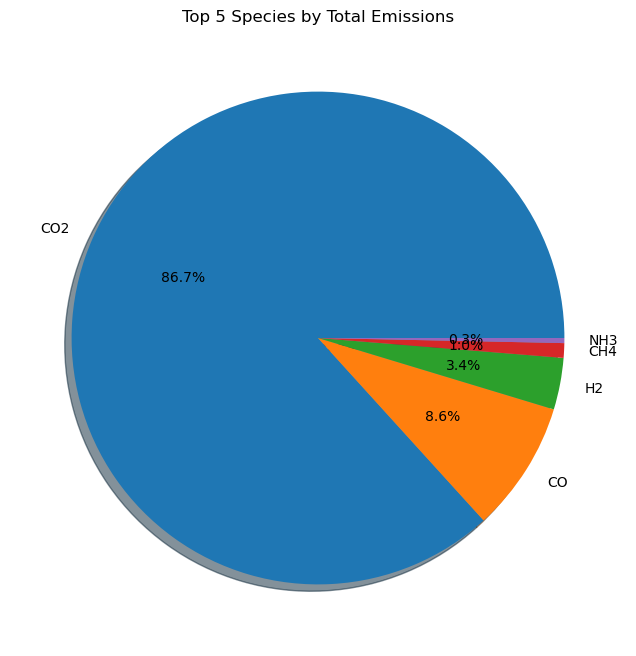

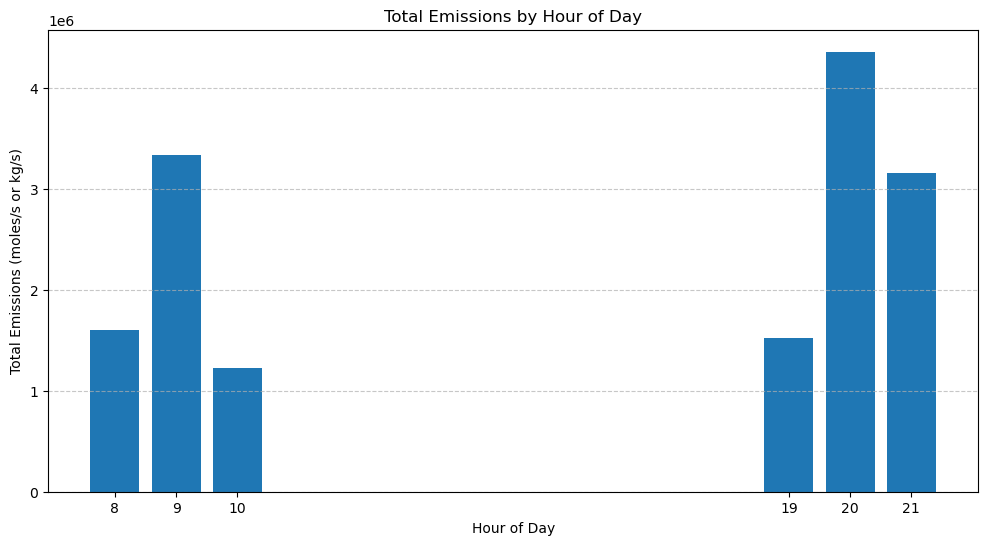

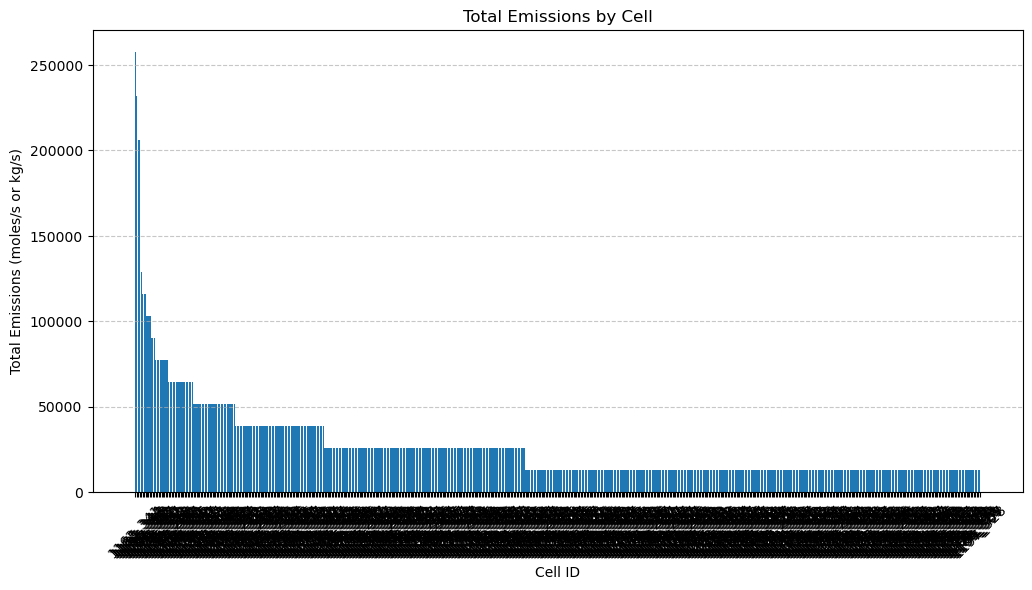

In [24]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import glob

def summarize_emissions(nc_dir="E:\\CARB\\SAPRC07\\NC_Output"):
    """
    Summarize fire emissions across all NetCDF files in the directory
    
    Parameters:
    nc_dir (str): Directory containing the NetCDF files
    """
    # Find all NetCDF files in the directory
    nc_files = glob.glob(os.path.join(nc_dir, "fire_emissions_*.nc"))
    
    if not nc_files:
        print(f"No NetCDF files found in {nc_dir}")
        return
    
    print(f"Found {len(nc_files)} NetCDF files")
    
    # Initialize dictionaries to store summary data
    all_dates = []
    total_by_species = {}
    total_by_cell = {}
    total_by_hour = {}
    max_hourly_emissions = {}
    
    # Process each file
    for nc_file in nc_files:
        filename = os.path.basename(nc_file)
        date_str = filename.replace("fire_emissions_", "").replace(".nc", "")
        all_dates.append(date_str)
        
        print(f"\nProcessing {date_str}...")
        
        # Open the NetCDF file
        ds = xr.open_dataset(nc_file)
        
        # Get base emissions
        if 'base_emissions' in ds.data_vars:
            base_emissions = ds['base_emissions']
            species_names = ds.base_species.values
            
            # 1. Total emissions by species for this date
            daily_species_total = base_emissions.sum(dim=["cell", "hour"]).values
            
            # Add to overall totals
            for i, species in enumerate(species_names):
                if species in total_by_species:
                    total_by_species[species] += daily_species_total[i]
                else:
                    total_by_species[species] = daily_species_total[i]
            
            # 2. Total emissions by cell for this date
            cells = ds.cell.values
            daily_cell_total = base_emissions.sum(dim=["hour", "base_species"]).values
            
            for i, cell in enumerate(cells):
                if cell in total_by_cell:
                    total_by_cell[cell] += daily_cell_total[i]
                else:
                    total_by_cell[cell] = daily_cell_total[i]
            
            # 3. Total emissions by hour for this date
            hours = ds.hour.values
            daily_hour_total = base_emissions.sum(dim=["cell", "base_species"]).values
            
            for i, hour in enumerate(hours):
                hour_key = int(hour)
                if hour_key in total_by_hour:
                    total_by_hour[hour_key] += daily_hour_total[i]
                else:
                    total_by_hour[hour_key] = daily_hour_total[i]
            
            # 4. Max emissions by species and hour (for the whole dataset)
            hourly_species_emissions = base_emissions.sum(dim="cell")
            
            for i, species in enumerate(species_names):
                for j, hour in enumerate(hours):
                    emission_value = hourly_species_emissions.values[j, i]
                    
                    if species not in max_hourly_emissions:
                        max_hourly_emissions[species] = {
                            'value': emission_value,
                            'hour': int(hour),
                            'date': date_str
                        }
                    elif emission_value > max_hourly_emissions[species]['value']:
                        max_hourly_emissions[species] = {
                            'value': emission_value,
                            'hour': int(hour),
                            'date': date_str
                        }
        
        # Close the dataset
        ds.close()
    
    # Print summary statistics
    print("\n========== EMISSIONS SUMMARY ==========")
    print(f"Analysis period: {min(all_dates)} to {max(all_dates)}")
    print(f"Total number of days: {len(all_dates)}")
    
    # 1. Total emissions by species
    print("\n----- TOTAL EMISSIONS BY SPECIES (MOLES/S OR KG/S) -----")
    species_df = pd.DataFrame({
        'Species': list(total_by_species.keys()),
        'Total_Emissions': list(total_by_species.values())
    })
    species_df = species_df.sort_values('Total_Emissions', ascending=False)
    print(species_df.to_string(index=False))
    
    # 2. Total emissions by cell
    print("\n----- TOTAL EMISSIONS BY CELL (ALL SPECIES COMBINED) -----")
    cell_df = pd.DataFrame({
        'Cell_ID': list(total_by_cell.keys()),
        'Total_Emissions': list(total_by_cell.values())
    })
    cell_df = cell_df.sort_values('Total_Emissions', ascending=False)
    print(cell_df.to_string(index=False))
    
    # 3. Total emissions by hour
    print("\n----- TOTAL EMISSIONS BY HOUR (ALL SPECIES COMBINED) -----")
    hour_df = pd.DataFrame({
        'Hour': list(total_by_hour.keys()),
        'Total_Emissions': list(total_by_hour.values())
    })
    hour_df = hour_df.sort_values('Hour')
    print(hour_df.to_string(index=False))
    
    # 4. Max hourly emissions by species
    print("\n----- MAXIMUM HOURLY EMISSIONS BY SPECIES -----")
    max_df = pd.DataFrame([
        {
            'Species': species,
            'Max_Emission': info['value'],
            'Hour': info['hour'],
            'Date': info['date']
        }
        for species, info in max_hourly_emissions.items()
    ])
    max_df = max_df.sort_values('Max_Emission', ascending=False)
    print(max_df.to_string(index=False))
    
    # Create visualizations
    print("\nCreating visualizations...")
    
    # Top species pie chart
    plt.figure(figsize=(10, 8))
    top_species = species_df.head(5)
    plt.pie(top_species['Total_Emissions'], labels=top_species['Species'], autopct='%1.1f%%', shadow=True)
    plt.title('Top 5 Species by Total Emissions')
    plt.savefig(os.path.join(nc_dir, 'top_species_pie.png'), dpi=300, bbox_inches='tight')
    
    # Emissions by hour bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(hour_df['Hour'], hour_df['Total_Emissions'])
    plt.xlabel('Hour of Day')
    plt.ylabel('Total Emissions (moles/s or kg/s)')
    plt.title('Total Emissions by Hour of Day')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(hour_df['Hour'])
    plt.savefig(os.path.join(nc_dir, 'emissions_by_hour.png'), dpi=300, bbox_inches='tight')
    
    # Emissions by cell bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(cell_df['Cell_ID'], cell_df['Total_Emissions'])
    plt.xlabel('Cell ID')
    plt.ylabel('Total Emissions (moles/s or kg/s)')
    plt.title('Total Emissions by Cell')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.savefig(os.path.join(nc_dir, 'emissions_by_cell.png'), dpi=300, bbox_inches='tight')
    
    print("\nSummary analysis complete!")
    print(f"Visualizations saved to {nc_dir}")

# Execute the summary function
if __name__ == "__main__":
    summarize_emissions()